In [18]:
import pandas as pd
import numpy as np
import random
from pprint import pprint
import sys
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

from scipy.stats import entropy
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter

from scipy.stats import sem

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)

COL_WIDTH=250
CMAP = 'seismic_r'
_CMAP = 'viridis'
pd.options.display.max_colwidth = COL_WIDTH

EASY_THRESH = 0.75
MEDIUM_THRESH = 0.5
HARD_THRESH = 0.25
IMPOSSIBLE_THRESH = 0.0
ALPHA = 0.6

SEEDS = [42, 43, 44, 46]
BASE_PATH = '/Users/ardsnijders/Desktop/AL_backup/results/ard_output_dir_results/datamaps/test/datamap_test_subepoch_inference_elke_0.5_epochs/roberta-large/random/SEED/confidences.pickle'
# BASE_PATH = '/Users/ardsnijders/Documents/GitHub/Lisa/active_learning_backup/results/ard_output_dir_results/datamap/test/datamap_op_test_set_subepoch_inference_elke_0.5_epochs_max_4_epochs/random/SEED/datamap.pickle'
STRATEGY_PATH = "/Users/ardsnijders/Desktop/AL_backup/results/ard_output_dir_results/acquisition_IDs/array/main_experiment_herhaald_dubbele_acq_batch_size_woensdag/roberta-large/STRATEGY/SEED/acquisition_ids.csv"


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Loading pickled confidences

In [19]:
def load_confidences(path, predictions=False, exclude=1, up_to=-1):

    df = pd.read_pickle(path)
    sample_ids = list(df.keys())

    cartography_dict = {}
    prediction_dict = {}

    for sample_id in sample_ids:

        times_correct = []
        confidences = []

        outputs = df[sample_id]
        outputs = outputs[exclude:]#[:up_to] # don't count the first 0.5 epoch!

        for output in outputs:

            # extract values from output tuple
            prediction = output[0]
            label = output[1]

            # obtain GT confidence, determine correctness of prediction
            confidence = prediction[label]
            correct = 1 if prediction.index(max(prediction)) == label else 0

            # track confidence and correctness
            confidences.append(confidence)
            times_correct.append(correct)


        cartography_dict[sample_id] = {'confidence': np.mean(confidences),
                                      'variability': np.std(confidences),
                                      'correctness': np.mean(times_correct)}

        prediction_dict[sample_id] = {'prediction': outputs[-1][0]}

    confidences = [cartography_dict[key]['confidence'] for key in list(cartography_dict.keys())]
    variability = [cartography_dict[key]['variability'] for key in list(cartography_dict.keys())]
    correctness = [cartography_dict[key]['correctness'] for key in list(cartography_dict.keys())]

    df = pd.DataFrame(list(zip(sample_ids, confidences, variability, correctness)), columns=['id', 'mean_conf', 'variability', 'correctness'])
    
    if predictions == False:
        return df
    else:
        return df, prediction_dict

# Code to read datasets

In [20]:
def read_dataset(input_dir, dataset_id, split, seed, wanli_id):
    """
    This function takes a dataset id and reads the corresponding .json split in an appropriate Pandas DataFrame
    :param wanli_id: id key for wanli json file (pairID for metrics, id for non metric stuff)
    :param seed:
    :param input_dir:
    :param dataset_id: str indicating which dataset should be read
    :param split: str indicating which split should be read
    :return: DataFrame with examples (Premise, Hypothesis, Label, ID)
    """
    # anli_rounds = ['ANLI_R1', 'ANLI_R2', 'ANLI_R3']
    anli_rounds = ['ANLI_R2', 'ANLI_R3']

    def replace_labels(label):
        label_conversions = {'e': 'entailment',
                             'c': 'contradiction',
                             'n': 'neutral'}

        return label_conversions[label]

    if dataset_id == 'SNLI':

        # TODO only consider snli with gold labels?
        data_path = '{}/snli_1.0/snli_1.0_{}.jsonl'.format(input_dir, split)
        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['sentence1', 'sentence2', 'gold_label', 'pairID']]
        dataset['dataset'] = 'SNLI'
        dataset = dataset.drop(dataset[dataset.gold_label.str.contains('-')].index)  # drop examples with no gold label

    # load separate ANLI rounds
    elif dataset_id in anli_rounds:

        data_round = dataset_id[-2:]  # extract the 'R#' substring from the provided ID
        data_path = '{}/anli_v1.0/{}/{}.jsonl'.format(input_dir, data_round, split)
        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['context', 'hypothesis', 'label', 'uid']]  # get rid of unnecessary columns
        dataset['label'] = dataset['label'].apply(replace_labels)  # ensures consistently named labels
        dataset['dataset'] = 'ANLI_{}'.format(data_round)
        #
        # print('Dataframe for {} - {}'.format(dataset_id, split), flush=True)

    # compile all ANLI rounds
    elif dataset_id == 'ANLI':

        dataset_list = []
        for data_round in anli_rounds:
            data_round = data_round[-2:]
            data_path = '{}/anli_v1.0/{}/{}.jsonl'.format(input_dir, data_round, split)
            dataset = pd.read_json(data_path, lines=True)
            dataset = dataset[['context', 'hypothesis', 'label', 'uid']]  # get rid of unnecessary columns
            dataset['label'] = dataset['label'].apply(replace_labels)  # ensures consistently named labels
            dataset['dataset'] = 'ANLI'
            dataset_list.append(dataset)
        dataset = pd.concat(dataset_list, axis=0)

    # Load MNLI
    elif dataset_id == 'MNLI':

        if split == 'train':
            data_path = '{}/multinli_1.0/multinli_1.0_{}.jsonl'.format(input_dir, split)
        elif split == 'dev' or split == 'test':
            data_path = '{}/multinli_1.0/multinli_1.0_dev_matched.jsonl'.format(input_dir)

        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['sentence1', 'sentence2', 'gold_label', 'pairID']]
        dataset['dataset'] = 'MNLI'
        dataset = dataset.drop(dataset[dataset.gold_label.str.contains('-')].index)

        # split dev into dev and test set
        if split == 'dev':
            dataset = dataset.sample(frac=1,  # reshuffle all rows in the dataframe prior to split
                                     random_state=seed)  # seed is fixed such that dev and test set are always the same
            dataset = dataset[:int((len(dataset)/2))]

        elif split == 'test':
            dataset = dataset.sample(frac=1,
                                     random_state=seed)
            dataset = dataset[int((len(dataset)/2)):]

    # Load WANLI
    elif dataset_id == 'WANLI':

        if split == 'train':
            data_path = '{}/wanli/train.jsonl'.format(input_dir)
        elif split == 'dev' or split == 'test':
            data_path = '{}/wanli/test.jsonl'.format(input_dir)

        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['premise', 'hypothesis', 'gold', wanli_id]]
        dataset['dataset'] = 'WANLI'
        dataset = dataset.drop(dataset[dataset.gold.str.contains('-')].index)

        # split dev into dev and test set
        if split == 'dev':
            dataset = dataset.sample(frac=1,  # reshuffle all rows in the dataframe prior to split
                                     random_state=seed)  # seed is fixed such that dev and test set are always the same
            dataset = dataset[:int((len(dataset) / 2))]

        elif split == 'test':
            dataset = dataset.sample(frac=1,
                                     random_state=seed)
            dataset = dataset[int((len(dataset) / 2)):]

    else:
        raise KeyError('No dataset found for "{}"'.format(dataset_id))

    # ensure consistent headers per dataset DataFrame
    dataset.columns = ['Premise', 'Hypothesis', 'Label', 'ID', 'Dataset']

    dataset['ID'] = dataset['ID'].astype('string')

    return dataset

In [24]:
INPUT_DIR='/Users/ardsnijders/Desktop/AL_backup/resources/ard_data'
SPLIT='train'
WANLI_ID='pairID'



def read_source(dataset_id, split='train'):
    dataset = read_dataset(input_dir=INPUT_DIR, 
                 dataset_id=dataset_id, 
                 split=split, 
                 seed=None, 
                 wanli_id=WANLI_ID)
    return dataset

# Loading all datasets into their own DataFrame

# Code for Generating Datamaps for Different Sources / Strategies

In [25]:
def generate_df(dataframe):
    X = dataframe['variability'].tolist()
    Y = dataframe['mean_conf'].tolist()
    colors = dataframe['correctness'].tolist()

    plt.figure(figsize=(30, 10))
    plt.scatter(x=X, y=Y, c=colors, alpha=1, cmap=mpl.cm.get_cmap(CMAP))
    plt.xlim(0,0.5)
    plt.ylim(0,1)
    plt.xlabel('Variability')
    plt.ylabel('Confidence')
    plt.legend()
    plt.show()
    
def generate_source_map(base_df, source_df):

    ids = source_df.ID

    source_df = base_df[base_df.id.astype('string').isin(ids)]
    
    print('num of source in base: {}'.format(len(source_df)))
    
    generate_df(source_df)
    
def datamap_subset(base_df, source_df, name=None):
    
    source_ids = source_df.ID
    
    subset_df = base_df[base_df.id.astype('string').isin(source_ids)]

    if name is not None:
        subset_df['Name'] = name
    else:
        subset_df['Name'] = source_df.Dataset.tolist()[0]
    
    return subset_df

def datamap_subset_multi(base_path, source_df, name=None, up_to=False):
    
    list_of_maps = []
    
    source_ids = source_df.ID
    
    for seed in SEEDS:
        
        _base_path = base_path.replace('SEED', str(seed))
        
        base_df = load_confidences(_base_path, predictions=False, up_to=up_to)

        subset_df = base_df[base_df.id.astype('string').isin(source_ids)]

        if name is not None:
            subset_df['Name'] = name
        else:
            subset_df['Name'] = source_df.Dataset.tolist()[0]
            
        list_of_maps.append(subset_df)
    
    return list_of_maps

def generate_dfs_2(dataframes, markers=None, learnability_only=False, map_only=False, size=40, n_bins=10, font_size=20, up_to='None'):
    
    plt.rcParams.update({'font.size': font_size})
    
    def generate_hist(axis, data, name, color, colormap, n_bins=10):
        
        cmap = False
        if color == 'cmap':
            cmap = True
            color = 'green'
        
        n, bins, patches = axis.hist(data, 
                                     n_bins, 
                                     weights=np.ones(len(data)) / len(data), 
                                     density=False, 
                                     color=color)

        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        
        if cmap:
        
            # scale values to interval [0,1]
            col = bin_centers - min(bin_centers)
            col /= max(col)

            for c, p in zip(col, patches):
                plt.setp(p, 'facecolor', colormap(c))

        axis.set_xlabel(name)
        axis.set_ylim(0,1)

        axis.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    
    # creating grid for subplots
    fig = plt.figure()
    fig.set_figheight(size)
    fig.set_figwidth(size*1.5)
    
    ax1 = plt.subplot2grid(shape=(4, 4), loc=(0, 0), colspan=3, rowspan=4)
    ax2 = plt.subplot2grid(shape=(4, 4), loc=(0, 3), rowspan=1)
    ax3 = plt.subplot2grid(shape=(4, 4), loc=(1, 3), colspan=1)
    ax4 = plt.subplot2grid(shape=(4, 4), loc=(2, 3), rowspan=1)
    ax5 = plt.subplot2grid(shape=(4, 4), loc=(3, 3), rowspan=1)
    
    color_dict = {'SNLI':'red', 'ANLI':'green', 'WANLI':'blue'}
    
    for dataframe in dataframes:

        if markers is not None:

            for dataset, marker in zip(['ANLI', 'WANLI', 'SNLI'], ['s', 'x', 'o', 'v']):


                sub_frame = dataframe[dataframe['Dataset'] == dataset]
                
                sub_frame = sub_frame.sample(800)
                
                X = sub_frame['variability'].tolist()
                Y = sub_frame['mean_conf'].tolist()
#                 colors = sub_frame['correctness'].tolist()
#                 colors = [color_dict[dataset]]*len(sub_frame.tolist())
                
#                 ax1.scatter(x=X, y=Y, c=colors, alpha=1, marker=marker, cmap=mpl.cm.get_cmap(CMAP), 
#                             label=dataset, s=size*4)
                ax1.scatter(x=X, y=Y, c=color_dict[dataset], alpha=0.2,
                            label=dataset, s=size*4)

        else:


            X = dataframe['variability'].tolist()
            Y = dataframe['mean_conf'].tolist()
            colors = dataframe['correctness'].tolist()

            ax1.scatter(x=X, y=Y, c=colors, alpha=1, cmap=mpl.cm.get_cmap(CMAP), s=size)
        
        name = dataframe.Name.tolist()[0].upper()
        ax1.set_title('Dataset Map for ' + name)
        ax1.set_xlabel('Variability')
        ax1.set_ylabel('Confidence')

        if markers:
            ax1.legend(loc='upper right', prop={'size': 30})
            ax1.legend(markerscale=2)
            
        break # terminate loop for datamap after first seed since only one seed can be plotted
    
    
    easy = []
    medium = []
    hard = []
    impossible = []
    X = []
    Y = []
    correctness = []
    for dataframe in dataframes:
    
        X.extend( dataframe['variability'].tolist() )
        Y.extend( dataframe['mean_conf'].tolist() )
        correctness.extend( dataframe['correctness'].tolist() )

        easy.append( len(dataframe[dataframe['mean_conf'] > EASY_THRESH])  )
        medium.append( len(dataframe[(dataframe['mean_conf'] > MEDIUM_THRESH) & (dataframe['mean_conf'] < EASY_THRESH)])  )
        hard.append( len(dataframe[(dataframe['mean_conf'] > HARD_THRESH) & (dataframe['mean_conf'] < MEDIUM_THRESH)])   )
        impossible.append( len(dataframe[(dataframe['mean_conf'] > IMPOSSIBLE_THRESH) & (dataframe['mean_conf'] < HARD_THRESH)])  )
    
    # take the mean over difficulty brackets
    # TODO: generate std bars?
    def mean_and_std_e(array):
        
        return np.mean(array), np.std(array)
    
    easy, std_easy = mean_and_std_e(easy)
    medium, std_medium = mean_and_std_e(medium)
    hard, std_hard = mean_and_std_e(hard)
    impossible, std_impossible = mean_and_std_e(impossible)
    
#     std_easy, std_medium, std_hard, std_impossible = 200,30,400,20
    
    # LEARNABILITY      
    width = 1
    cmap = mpl.cm.get_cmap(CMAP)
    
    categories = ['E', 'M', 'H', 'I']
    x_pos = [0,1,2,3]
    means = [easy, medium, hard, impossible]
    
    
    y_err = [std_easy, std_medium, std_hard, std_impossible]
    
    normed_means = [mean / sum(means) for mean in means]
    y_err = [std / sum(means) for std in y_err]
    
    colors = [cmap(value) for value in [0.85, 0.65, 0.35, 0.125]]
    
    labels = [('[p > {}]'.format(thresh, color=cmap(value), alpha=ALPHA)) for thresh, value in zip([EASY_THRESH, MEDIUM_THRESH, HARD_THRESH, IMPOSSIBLE_THRESH],[0.85, 0.65, 0.35, 0.125])]
    ax2.bar(x_pos, normed_means, yerr=y_err, width=1, color=colors, capsize=10, alpha=ALPHA)
    
    print('values for {}'.format(name))
    for val, std, pctage in zip(normed_means, y_err, ['0.75', '0.5', '0.25', '0']):
        print('val, std for p > {} = {}, {}'.format(pctage, val, std))

    thresholds = [EASY_THRESH, MEDIUM_THRESH, HARD_THRESH, IMPOSSIBLE_THRESH]
    patches = [mpatches.Patch(color=value, label='[p > {}]'.format(thresh), alpha=ALPHA) for thresh, value in zip(thresholds, colors)]
    
    ax2.legend(handles=patches, loc='upper right')
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(categories)
    ax2.set_ylim(0,1)
    
#     ylabels = ['{}'.format(round(x,1)) + 'K' for x in ax2.get_yticks()[::1]/1000]
    ylabels = ['{}%'.format(int(x))  for x in ax2.get_yticks()[::1]*100]
    ax2.set_yticklabels(ylabels)
    if learnability_only:
        ax2.set_xlabel('{}'.format(name))
    else:
        ax2.set_xlabel('Learnability')
    ax2.legend(loc='upper right')

    
    # CORRECTNESS      
    generate_hist(axis=ax3, data=correctness, name='Correctness', color='cmap', colormap=mpl.cm.get_cmap(CMAP))

    # CONFIDENCES      
    generate_hist(axis=ax4, data=Y, name='Confidences', color='red', colormap=None)

    # VARIABILITY      
    generate_hist(axis=ax5, data=X, name='Variability', color='green', colormap=None)
    
    for ax in [ax2, ax3, ax4, ax5]:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.xaxis.set_label_position('top')
    
    plt.tight_layout()  
    
    if learnability_only:
        print('learnability {}'.format(name))
        ax1.remove()
        ax3.remove()
        ax4.remove()
        ax5.remove()
        
        plt.show(ax2)
        # Save just the portion _inside_ the second axis's boundaries
        extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig('learnability_{}.pdf'.format(name), format='pdf', bbox_inches=extent.expanded(1.55, 1.3))
#         plt.savefig('learnability_{}.pdf'.format(name), format='pdf')

    if map_only:
        ax2.remove()
        ax3.remove()
        ax4.remove()
        ax5.remove()
        
        plt.show(ax1)
        # Save just the portion _inside_ the second axis's boundaries
        extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig('map_only_{}_iter_{}.pdf'.format(name, up_to), format='pdf', bbox_inches=extent.expanded(1.55, 1.3))
#         plt.savefig('learnability_{}.pdf'.format(name), format='pdf')
    
    else:
        plt.savefig('datamap_{}_iter_{}.pdf'.format(name, up_to), format='pdf') 
        plt.show()

In [26]:
# mnli = read_source('MNLI')
snli = read_source('SNLI')
anli = read_source('ANLI')
wanli = read_source('WANLI')

In [28]:
snli.Label.value_counts()
# snli.Label.value_counts(normalize=True)

entailment       183416
contradiction    183187
neutral          182764
Name: Label, dtype: int64

# Datamaps per Source

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

values for ANLI
val, std for p > 0.75 = 0.6018697692419331, 0.02816470267944927
val, std for p > 0.5 = 0.20106671181848967, 0.018668407844484616
val, std for p > 0.25 = 0.11315369358037831, 0.008161164765577083
val, std for p > 0 = 0.08390982535919887, 0.0014393667985885385


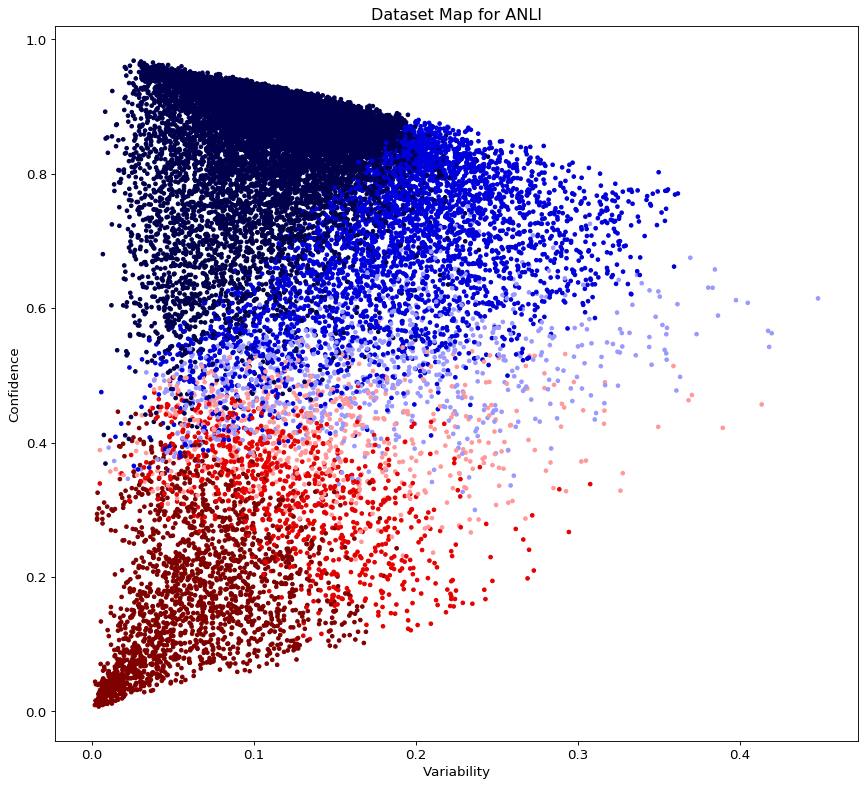

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

values for ANLI
val, std for p > 0.75 = 0.6018697692419331, 0.02816470267944927
val, std for p > 0.5 = 0.20106671181848967, 0.018668407844484616
val, std for p > 0.25 = 0.11315369358037831, 0.008161164765577083
val, std for p > 0 = 0.08390982535919887, 0.0014393667985885385


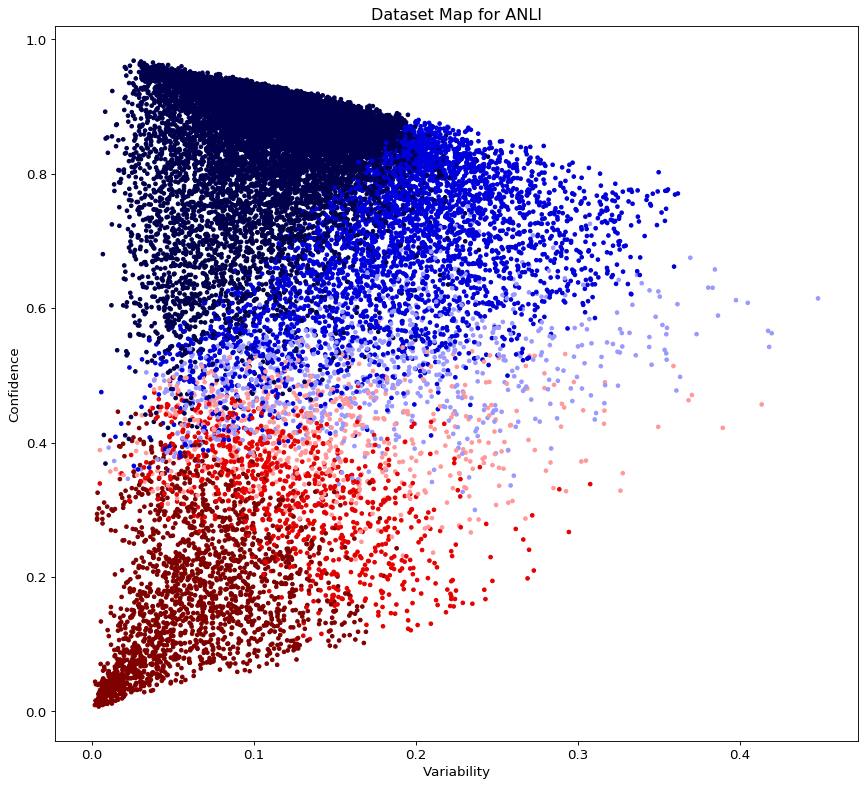

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

values for ANLI
val, std for p > 0.75 = 0.6018697692419331, 0.02816470267944927
val, std for p > 0.5 = 0.20106671181848967, 0.018668407844484616
val, std for p > 0.25 = 0.11315369358037831, 0.008161164765577083
val, std for p > 0 = 0.08390982535919887, 0.0014393667985885385


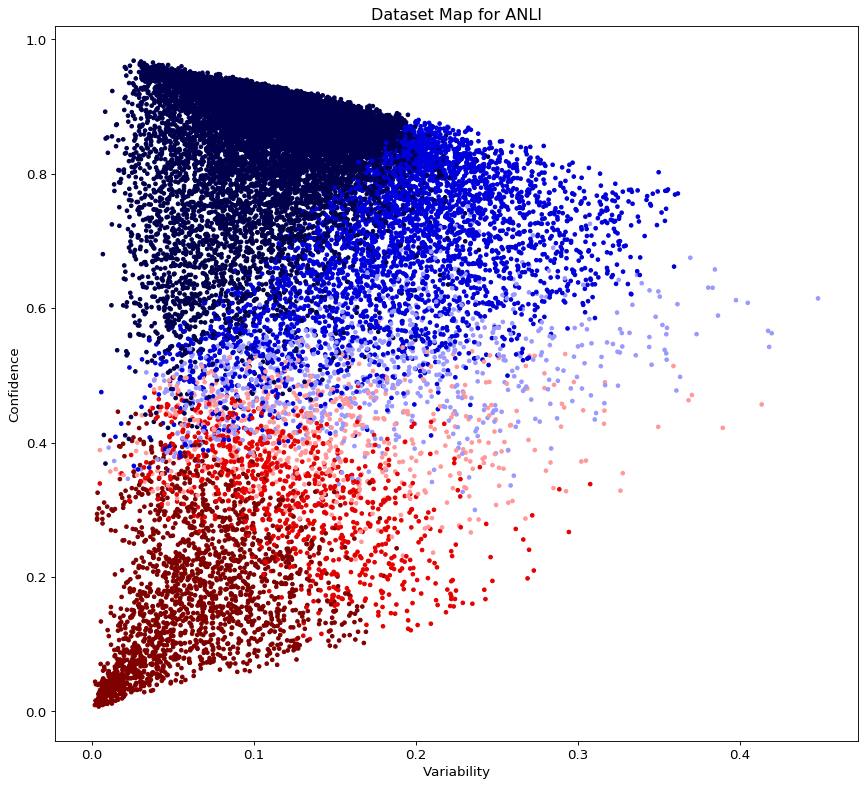

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

values for ANLI
val, std for p > 0.75 = 0.6018697692419331, 0.02816470267944927
val, std for p > 0.5 = 0.20106671181848967, 0.018668407844484616
val, std for p > 0.25 = 0.11315369358037831, 0.008161164765577083
val, std for p > 0 = 0.08390982535919887, 0.0014393667985885385


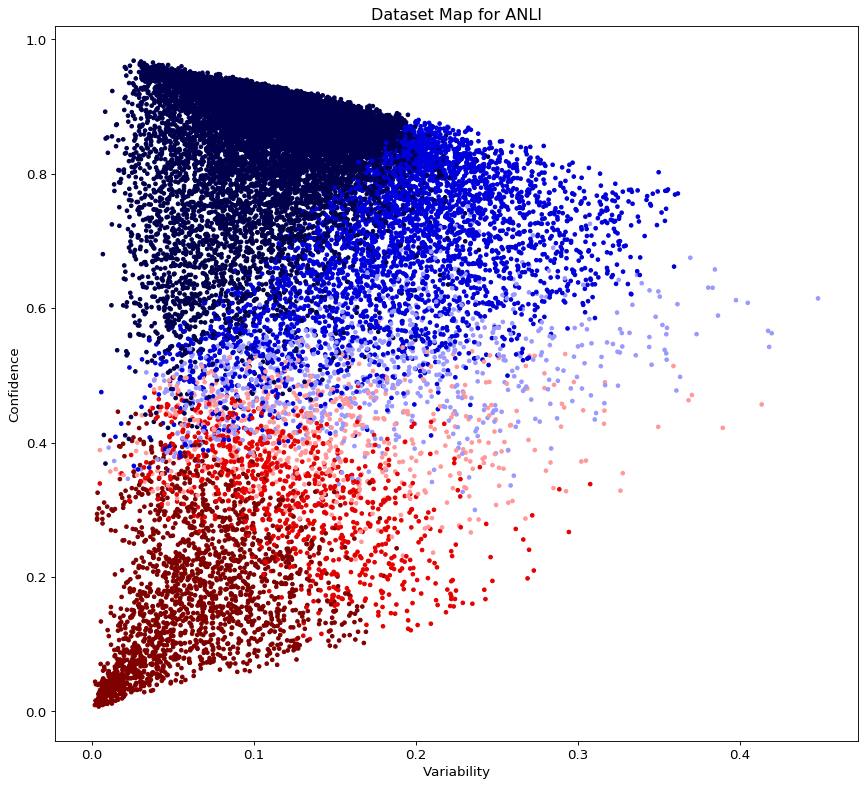

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

values for ANLI
val, std for p > 0.75 = 0.6018697692419331, 0.02816470267944927
val, std for p > 0.5 = 0.20106671181848967, 0.018668407844484616
val, std for p > 0.25 = 0.11315369358037831, 0.008161164765577083
val, std for p > 0 = 0.08390982535919887, 0.0014393667985885385


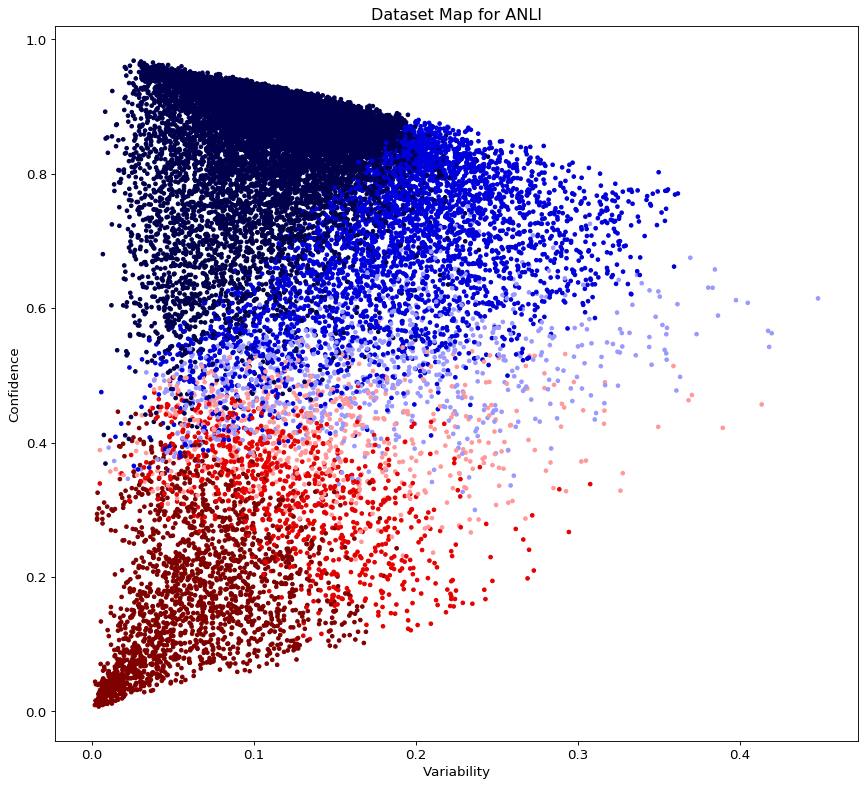

In [8]:
plt.rcParams['figure.dpi'] = 80
SIZE = 10
FONT_SIZE = 12

for iteration in range(2,7):
    
    anli_maps = datamap_subset_multi(base_path=BASE_PATH, source_df=anli, up_to=iteration)
    generate_dfs_2(anli_maps, size=SIZE, font_size=FONT_SIZE, up_to=iteration, map_only=True)

In [29]:
snli_maps = datamap_subset_multi(base_path=BASE_PATH, source_df=snli)
anli_maps = datamap_subset_multi(base_path=BASE_PATH, source_df=anli)
wanli_maps = datamap_subset_multi(base_path=BASE_PATH, source_df=wanli)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

No handles with labels found to put in legend.


values for ANLI
val, std for p > 0.75 = 0.6018697692419331, 0.02816470267944927
val, std for p > 0.5 = 0.20106671181848967, 0.018668407844484616
val, std for p > 0.25 = 0.11315369358037831, 0.008161164765577083
val, std for p > 0 = 0.08390982535919887, 0.0014393667985885385


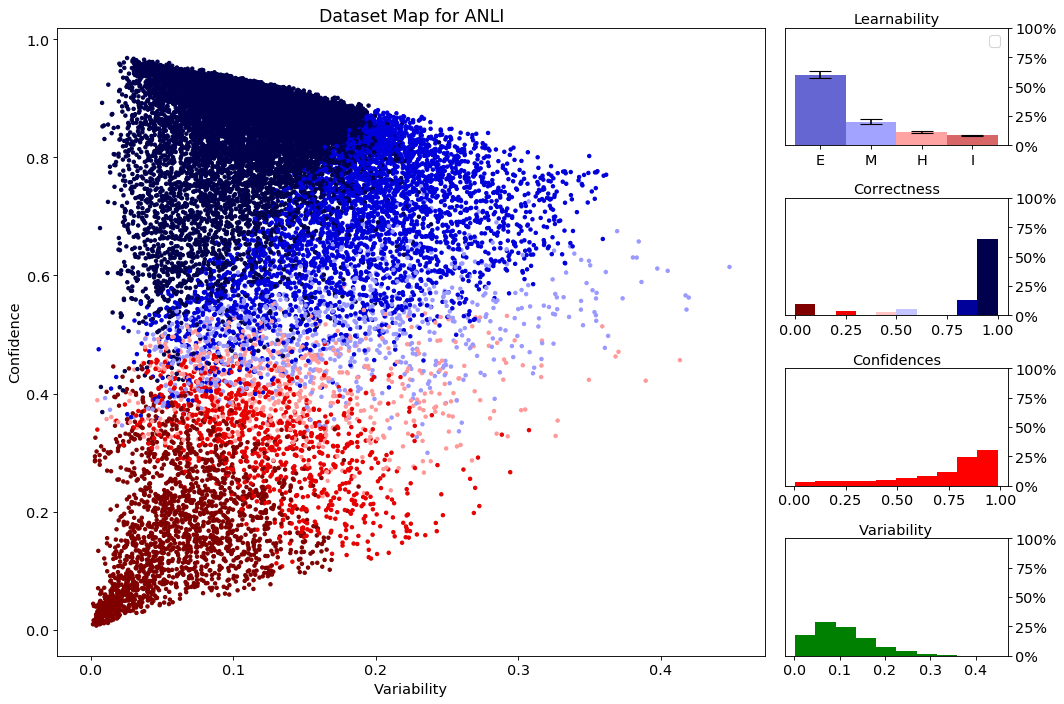

No handles with labels found to put in legend.


values for SNLI
val, std for p > 0.75 = 0.7828865979381443, 0.008913652019033469
val, std for p > 0.5 = 0.09307459066100666, 0.007547397136051078
val, std for p > 0.25 = 0.05069739235900546, 0.002605129454619063
val, std for p > 0 = 0.07334141904184355, 0.0009825633079238024


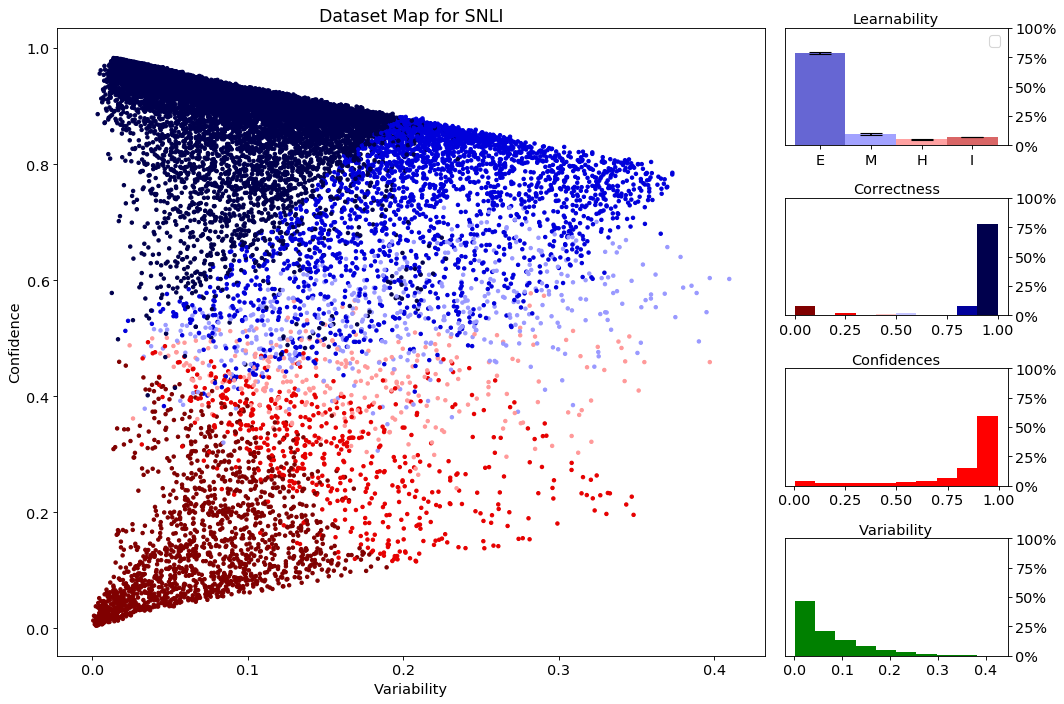

No handles with labels found to put in legend.


values for WANLI
val, std for p > 0.75 = 0.3680994317789053, 0.0382182233543834
val, std for p > 0.5 = 0.32344361338845035, 0.028376783573517986
val, std for p > 0.25 = 0.1935684561253128, 0.012692188276250642
val, std for p > 0 = 0.11488849870733157, 0.006805265415679207


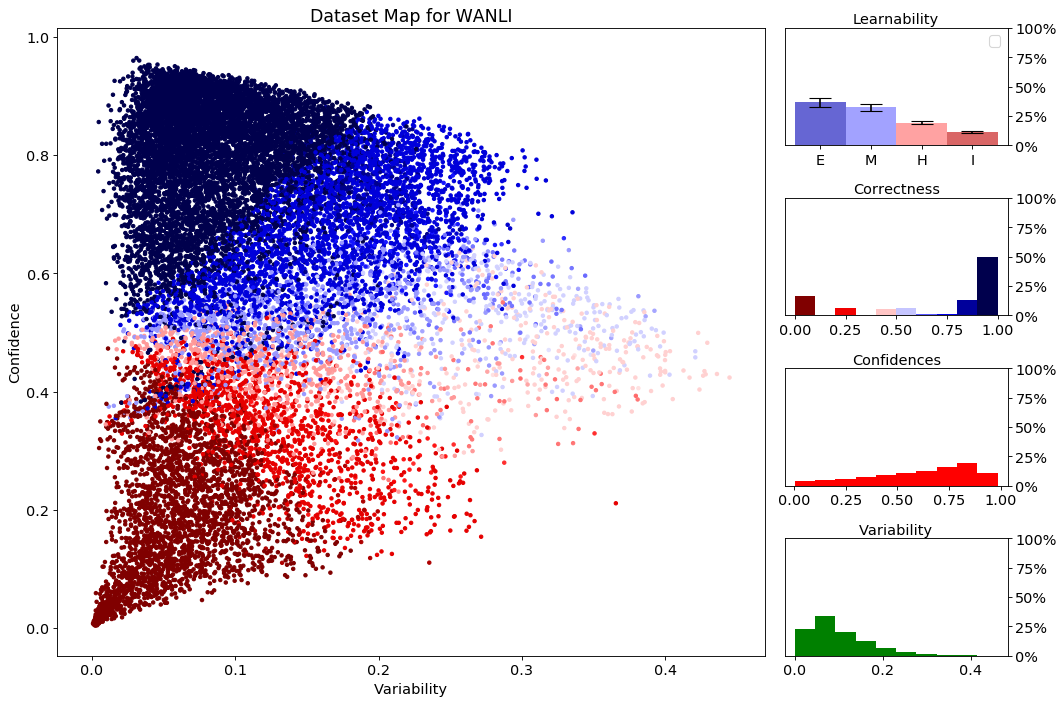

In [10]:
plt.rcParams['figure.dpi'] = 80
SIZE = 9
FONT_SIZE = 13
generate_dfs_2(anli_maps, size=SIZE, font_size=FONT_SIZE)
generate_dfs_2(snli_maps, size=SIZE, font_size=FONT_SIZE)
generate_dfs_2(wanli_maps, size=SIZE, font_size=FONT_SIZE)

# Datamaps per Strategy

In [13]:
for strategy in ['random', 'dal', 'bald', 'mc-max-entropy']:
    
    label_dict = {'neutral': [], 'entailment': [], 'contradiction': []}
    for seed in SEEDS:
        
        _strategy_path = STRATEGY_PATH.replace('SEED', str(seed)).replace('STRATEGY', str(strategy))
        strategy_df = load_strategy_acquisitions(path=_strategy_path, strategy=strategy)
        strategy_df.ID = strategy_df.ID.astype('str')
        
        
        label_counts = strategy_df.Label.value_counts(normalize=True)
        
        for key in list(label_dict.keys()):
            label_dict[key].append(label_counts[key])
            
    
    label_dict = {key:round(np.mean(label_dict[key]),2) for key in list(label_dict.keys())}
    print('label distribution for {}: {}'.format(strategy, label_dict))

label distribution for random: {'neutral': 0.41, 'entailment': 0.34, 'contradiction': 0.25}
label distribution for dal: {'neutral': 0.46, 'entailment': 0.34, 'contradiction': 0.2}
label distribution for bald: {'neutral': 0.32, 'entailment': 0.32, 'contradiction': 0.36}
label distribution for mc-max-entropy: {'neutral': 0.38, 'entailment': 0.31, 'contradiction': 0.32}


In [30]:
def load_strategy_acquisitions(path, strategy, cap=4000):
    
    acquired_df = pd.read_csv(path)
    acquired_df = acquired_df[:cap]
    acquired_df['Name'] = strategy.capitalize()
    
    return acquired_df

In [31]:
def get_subset_list(strategy_path, base_path, strategy_list):
    
    subset_list = []
    
    for strategy in strategy_list:
        
        strategy_list = []
        
        for seed in SEEDS:
            
            _base_path = base_path.replace('SEED', str(seed))
            _strategy_path = strategy_path.replace('SEED', str(seed)).replace('STRATEGY', str(strategy))
            
            strategy_df = load_strategy_acquisitions(path=_strategy_path, strategy=strategy)
            strategy_df.ID = strategy_df.ID.astype('str')
            
#             print(strategy_df.Label.value_counts(normalize=True))
            
            base_df = load_confidences(_base_path)
            
            
            
#             sys.exit()

            id2dataset = {}
            for i in range(len(strategy_df)):
                row = strategy_df.iloc[i]
                id2dataset[row.ID] = row.Dataset

            strategy_subset = datamap_subset(base_df=base_df, source_df=strategy_df, name=strategy)
            
            strategy_subset['Dataset'] = strategy_subset['id'].apply(lambda x: id2dataset[x])
            
            strategy_list.append(strategy_subset)
        
        subset_list.append(strategy_list)

    return subset_list 

subset_list = get_subset_list(strategy_path=STRATEGY_PATH, base_path=BASE_PATH, strategy_list=['random', 'bald', 'mc-max-entropy', 'dal'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [16]:
subset_list_sampled = []
for subset_maps in subset_list:
    subset_maps_sampled = [subset_map.sample(2000) for subset_map in subset_maps]
    subset_list_sampled.append(subset_maps_sampled)

No handles with labels found to put in legend.


values for RANDOM
val, std for p > 0.75 = 0.5766748135614463, 0.021206386362711622
val, std for p > 0.5 = 0.2160807169267406, 0.01582622710300392
val, std for p > 0.25 = 0.11919533746944914, 0.008194959472721702
val, std for p > 0 = 0.08804913204236385, 0.005993604675802536


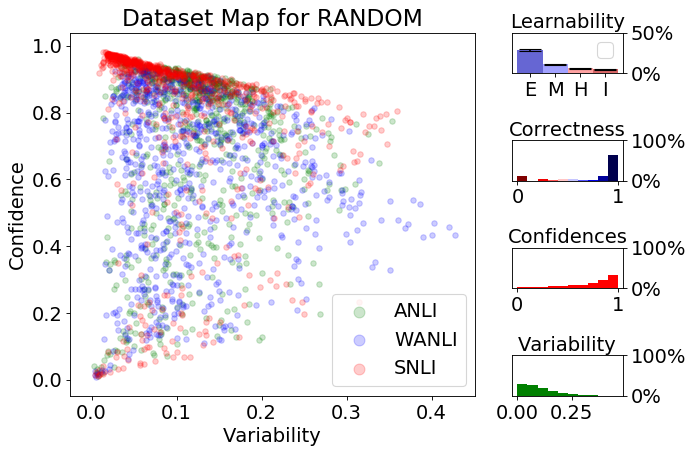

No handles with labels found to put in legend.


values for BALD
val, std for p > 0.75 = 0.5287967947915363, 0.018800019089840955
val, std for p > 0.5 = 0.21403530737448354, 0.015848378832361024
val, std for p > 0.25 = 0.1330912733191436, 0.009215008355906948
val, std for p > 0 = 0.12407662451483661, 0.006358314223410353


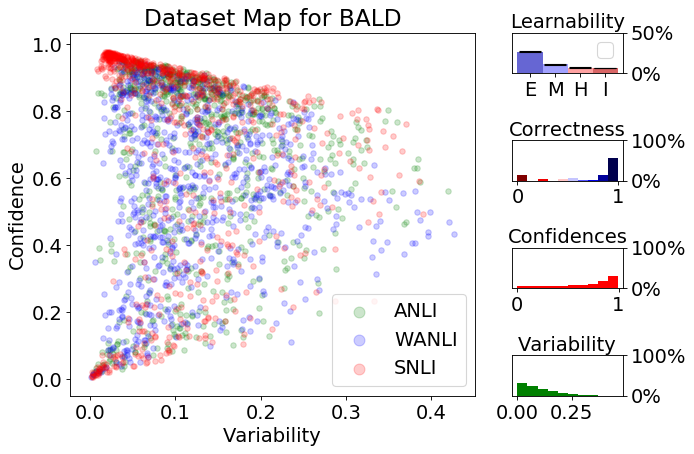

No handles with labels found to put in legend.


values for MC-MAX-ENTROPY
val, std for p > 0.75 = 0.38860688099266777, 0.028936460727191422
val, std for p > 0.5 = 0.27523970671178793, 0.01709642317020001
val, std for p > 0.25 = 0.19590148524158676, 0.014361327126054712
val, std for p > 0 = 0.1402519270539575, 0.0007200053451824314


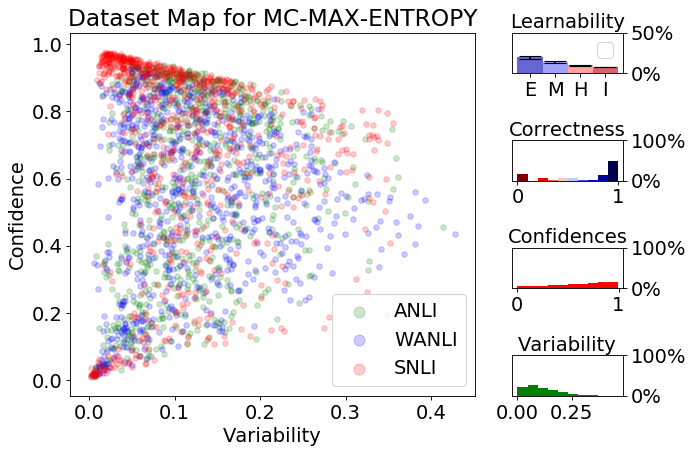

No handles with labels found to put in legend.


values for DAL
val, std for p > 0.75 = 0.5082234777150031, 0.021212255552217653
val, std for p > 0.5 = 0.25204017576898935, 0.017269644339850627
val, std for p > 0.25 = 0.14030131826741996, 0.006466397255513896
val, std for p > 0 = 0.09943502824858758, 0.0030804379526391205


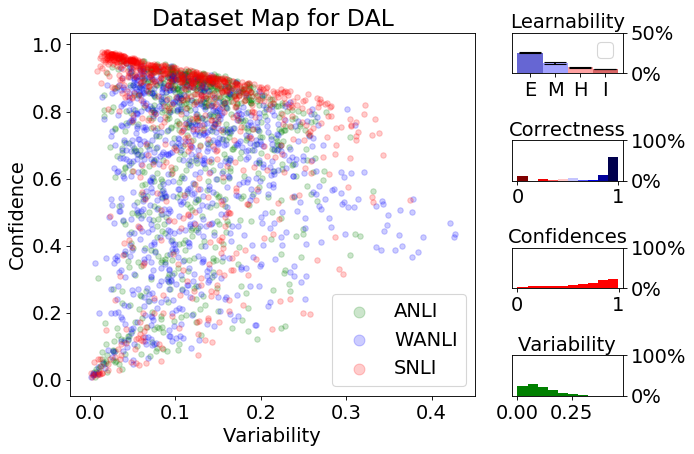

In [17]:
# generate_dfs(subset_list, markers=True, size=100, n_bins=10)

plt.rcParams['figure.dpi'] = 80
SIZE = 6
FONT_SIZE = 17.5

for subset_maps in subset_list:
    generate_dfs_2(subset_maps, markers=True, size=SIZE, font_size=FONT_SIZE) #map_only=True)

# Acquisitions by Difficulty over Time

In [18]:
def generate_stacked_barchart(base_dfs, strategy_dfs, return_axs=False, size=20, font_size=22, dpi=40, show_legend=True):
    
    plt.rcParams.update({'font.size': font_size})
    # Call this fn for a single strategy!
    
    num_easy_aggregate = []
    num_medium_aggregate = []
    num_hard_aggregate = []
    num_impossible_aggregate = []
    
    for strategy_df, base_df in zip(strategy_dfs, base_dfs):
        
        number_of_examples = 500

        labels = []
        num_easy = []
        num_medium = []
        num_hard = []
        num_impossible = []

        easy_thresh = 0.75
        medium_thresh = 0.5
        hard_thresh = 0.25
        impossible_thresh = 0.0

        for active_round in range(1, strategy_df['round'].max()+1):

            acquisitions = strategy_df[strategy_df['round']==active_round]
            number_of_examples += len(acquisitions)
            labels.append(number_of_examples)

            confidences = base_df[base_df.id.isin(acquisitions.ID)]

            easy_mask = confidences.mean_conf > easy_thresh
            medium_mask = (confidences.mean_conf > medium_thresh) & (confidences.mean_conf < easy_thresh)
            hard_mask = (confidences.mean_conf > hard_thresh) & (confidences.mean_conf < medium_thresh)
            impossible_mask = (confidences.mean_conf > impossible_thresh) & (confidences.mean_conf < hard_thresh)

            num_easy.append(len(confidences[easy_mask]))
            num_medium.append(len(confidences[medium_mask]))
            num_hard.append(len(confidences[hard_mask]))
            num_impossible.append(len(confidences[impossible_mask]))
            
        num_easy_aggregate.append(num_easy)
        num_medium_aggregate.append(num_medium)
        num_hard_aggregate.append(num_hard)
        num_impossible_aggregate.append(num_impossible)
        
    def get_mean_and_std_e(array):
        
        return np.mean(array, axis=0), np.std(array, axis=0)
    
    num_easy, num_easy_std = get_mean_and_std_e(num_easy_aggregate)    
    num_medium, num_medium_std = get_mean_and_std_e(num_medium_aggregate)
    num_hard, num_hard_std = get_mean_and_std_e(num_hard_aggregate)
    num_impossible, num_impossible_std = get_mean_and_std_e(num_impossible_aggregate)  

    fig, ax = plt.subplots(figsize=(size,size))
    plt.rcParams['figure.dpi'] = dpi

    width = 210
    alpha = ALPHA
    labels = np.array(labels)

    cmap = mpl.cm.get_cmap(CMAP)

    ax.bar(labels, num_easy, width, yerr=num_easy_std, label='Easy [{} < p < 1.0]'.format(easy_thresh), color=cmap(0.85), alpha=alpha)
    ax.bar(labels, num_medium, width, yerr=num_medium_std, bottom=num_easy,  label='Med. [{} < p < {}]'.format(medium_thresh, easy_thresh), color=cmap(0.65), alpha=alpha)
    ax.bar(labels, num_hard, width, yerr=num_hard_std, bottom=num_easy + num_medium, label='Hard [{} < p < {}]'.format(hard_thresh, medium_thresh), color=cmap(0.35), alpha=alpha)
    ax.bar(labels, num_impossible, width, yerr=num_impossible_std, bottom=num_easy + num_medium + num_hard, label='Imp. [0 < p < {}]'.format(hard_thresh), color=cmap(0.125), alpha=alpha)

#     ax.set_xticks(ax.get_xticks()[2:])
#     ax.set_ylabel('Acquisition by Difficulty')
    ax.set_xlabel('Labeled Ex.')
    ax.set_ylim(0, 510)
    ax.set_title(strategy_df['Name'].tolist()[0])
    
    if show_legend:
        ax.legend(loc='lower right', prop={'size': 0.9*font_size})
    
    if return_axs:
        
        return ax
    
    else:
        
#         if impossible_only:
#             impossible_str = '_impossible_'
#         else:
#             impossible_str = ''
        
        plt.plot(stacked=True)
        name = strategy_df['Name'].tolist()[0]
        plt.savefig('acquisitions_by_difficulty_{}.pdf'.format(name), format='pdf', bbox_inches='tight')
        plt.show()
        
        return None
    

def generate_stacked_barchart_data(base_dfs, strategy_dfs, return_axs=False, impossible_only=False, size=20, font_size=22, dpi=40, show_legend=True):
    
    plt.rcParams.update({'font.size': font_size})
    # Call this fn for a single strategy!
    
    total_counts = {'SNLI':[], 'ANLI':[], 'WANLI':[]}
    
    for strategy_df, base_df in zip(strategy_dfs, base_dfs):
        
        number_of_examples = 500

        labels = []
        results = {'SNLI':[], 'ANLI':[], 'WANLI':[]}

        for active_round in range(1, strategy_df['round'].max()+1):

            acquisitions = strategy_df[strategy_df['round']==active_round]
            number_of_examples += len(acquisitions)
            
            if impossible_only:
                
                impossible_acquisitions = base_df[base_df.mean_conf < MEDIUM_THRESH]
                acquisitions = acquisitions[acquisitions.ID.isin(impossible_acquisitions.id)]
            
            labels.append(number_of_examples)
            
            data_counts = acquisitions.Dataset.value_counts()
            
            for dataset, value in zip(data_counts.index, data_counts):
                results[dataset].append(value)
            
            for dataset in list(results.keys()):
                
                if dataset not in data_counts.index:
                    
                    results[dataset].append(0)
        
        for key in list(total_counts.keys()):
            total_counts[key].append(results[key])
        
    mean_and_std = {'SNLI':[], 'ANLI':[], 'WANLI':[]}
    
    for key in list(results.keys()):
        mean_and_std[key].append(np.mean(total_counts[key], axis=0))
        mean_and_std[key].append(np.std(total_counts[key], axis=0))
        
    def get_mean_and_std_e(array):
        
        return np.mean(array, axis=0), np.std(array, axis=0) 

    fig, ax = plt.subplots(figsize=(size,size))
    plt.rcParams['figure.dpi'] = dpi
    
    if impossible_only:
        ax.set_ylim(0, 250)
    else:
        ax.set_ylim(0, 510)
        
    width = 210
    alpha = ALPHA
    labels = np.array(labels)

    cmap = mpl.cm.get_cmap(_CMAP)
    
    ax.bar(labels, mean_and_std['SNLI'][0], width, yerr=mean_and_std['SNLI'][1], label='SNLI', color=cmap(0.85), alpha=alpha)
    ax.bar(labels, mean_and_std['ANLI'][0], width, yerr=mean_and_std['ANLI'][1], bottom=mean_and_std['SNLI'][0],  label='ANLI', color=cmap(0.65), alpha=alpha)
    ax.bar(labels, mean_and_std['WANLI'][0], width, yerr=mean_and_std['WANLI'][1], bottom=mean_and_std['SNLI'][0] + mean_and_std['ANLI'][0], label='WANLI', color=cmap(0.35), alpha=alpha)

    ax.set_xticks(ax.get_xticks()[:])
#     ax.set_ylabel('Acquisition by Dataset')
    ax.set_xlabel('Labeled Ex.')
    
    if not impossible_only:     
        ax.set_title(strategy_df['Name'].tolist()[0])
        
    else:
        ax.set_title(strategy_df['Name'].tolist()[0])
    
    if show_legend:
        ax.legend(loc='lower right')
    
    if return_axs:
        
        return ax
    
    else:
        
        if impossible_only:
            impossible_str = '_impossible_'
        else:
            impossible_str = ''


        
        plt.plot(stacked=True)
        name = strategy_df['Name'].tolist()[0]
        plt.savefig('acquisitions_by_data_{}{}.pdf'.format(name,impossible_str), format='pdf')
#         plt.tight_layout()
        plt.show()
        
        return None

In [19]:
strategy_ids = ['random', 'mc-max-entropy', 'dal', 'bald']

strategies_list = []
for strategy_id in strategy_ids:
    
    strategy_list = []
    for seed in SEEDS:
        
        strategy_path = STRATEGY_PATH.replace('SEED', str(seed)).replace('STRATEGY', str(strategy_id))
        strategy_df = load_strategy_acquisitions(strategy=strategy_id, path=strategy_path) 
        strategy_df.ID = strategy_df.ID.astype('str')
        
        strategy_list.append(strategy_df)
    
    strategies_list.append(strategy_list)

In [20]:
base_dfs = [load_confidences(BASE_PATH.replace('SEED', str(seed)), predictions=False) for seed in SEEDS]

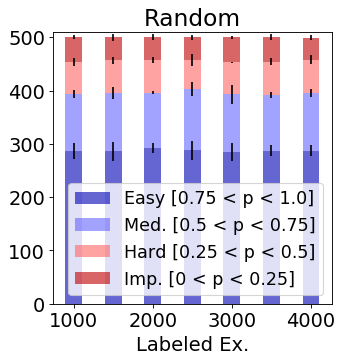

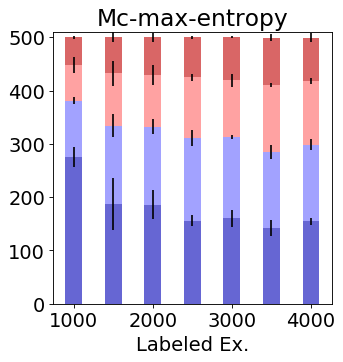

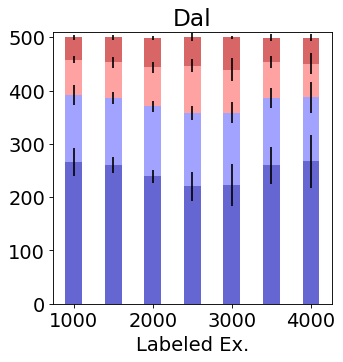

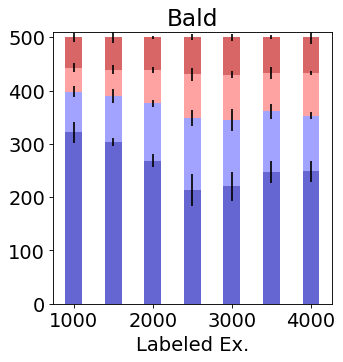

In [21]:
SIZE = 4.5
FONTSIZE = 17.5
DPI = 80

SHOW_LEGEND=True
axs = []
for strategy_df in strategies_list:
     generate_stacked_barchart(base_dfs=base_dfs, strategy_dfs=strategy_df, return_axs=False, size=SIZE, font_size=FONTSIZE, dpi=DPI, show_legend=SHOW_LEGEND)
#      generate_stacked_barchart_data(base_dfs=base_dfs, strategy_dfs=strategy_df, impossible_only=False, return_axs=False, size=SIZE, font_size=FONTSIZE, dpi=DPI, show_legend=SHOW_LEGEND)
#      generate_stacked_barchart_data(base_dfs=base_dfs, strategy_dfs=strategy_df, impossible_only=True, return_axs=False, size=SIZE, font_size=FONTSIZE, dpi=DPI, show_legend=SHOW_LEGEND)
     SHOW_LEGEND=False

# Examples of various difficulties:

In [32]:
EASY_THRESH = 0.75
MEDIUM_THRESH = 0.5
HARD_THRESH = 0.25
IMPOSSIBLE_THRESH = 0.0

COL_WIDTH = 25

_, prediction_dict = load_confidences(BASE_PATH.replace('SEED',str(42)), predictions=True)


HARD_THRESH = 0.25
def show_examples(source_df, source_map, base_df=None, num=5):
    
    source_map = source_map[0]
    
    difficulty_dict = {}
    
    easy_mask = source_map.mean_conf > EASY_THRESH
    medium_mask = (source_map.mean_conf > MEDIUM_THRESH) & (source_map.mean_conf < EASY_THRESH)
    hard_mask = (source_map.mean_conf > HARD_THRESH) & (source_map.mean_conf < MEDIUM_THRESH)
    impossible_mask = (source_map.mean_conf > IMPOSSIBLE_THRESH) & (source_map.mean_conf < 0.25)
    
    difficulty_dict['Easy'] = source_map[easy_mask]
    difficulty_dict['Medium'] = source_map[medium_mask]
    difficulty_dict['Hard'] = source_map[hard_mask]
    difficulty_dict['Impossible'] = source_map[impossible_mask]
    
#     print(source_df[source_df.ID=='dfaed736-3361-4401-a646-3d7f501eaabd'])
    
#     print('Examples from classes EASY, MEDIUM, HARD, and IMPOSSIBLE for {} \n'.format(source_map.Name.tolist()[0]))
    
#     print('\nConfidence Thresholds:\nEasy: {}\nMedium: {}\nHard: {}\nImpossible: {}\n'.format(EASY_THRESH, MEDIUM_THRESH, HARD_THRESH, IMPOSSIBLE_THRESH))
    
    id2label = {0: "entailment",
                1: "contradiction",
                2: "neutral"}
    
    for key in ['Impossible']:#difficulty_dict.keys():
        
        examples = source_df[source_df.ID.astype('str').isin(difficulty_dict[key].id.astype('string'))].head(num)
        examples['Model Prediction'] = examples.ID.apply(lambda x: id2label[np.argmax(prediction_dict[x]['prediction'])])
        examples['Model Confidence'] = examples.ID.apply(lambda x: round(np.max(prediction_dict[x]['prediction']),3))
        
        print(str(key).capitalize() + ' examples:')
        examples = examples[['Premise', 'Hypothesis', 'Label', 'Model Prediction', 'Model Confidence']]
        examples['Hypothesis'] = examples['Hypothesis'].str.wrap(COL_WIDTH).astype('string')
        examples['Premise'] = examples['Premise'].str.wrap(COL_WIDTH).astype('string')
        
        examples = examples.style.set_properties(**{'text-align': 'left'})
        examples = examples.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])
        display(examples)
   

show_examples(source_df=snli, source_map=snli_maps, base_df=None, num=50)
show_examples(source_df=wanli, source_map=wanli_maps, base_df=None, num=50)
show_examples(source_df=anli, source_map=anli_maps, base_df=None, num=50)

Impossible examples:


Impossible examples:


Impossible examples:


In [45]:
wanli[wanli.Premise.str.contains("with a stamp")]

Premise  \
4512   A piece of paper with a stamp on it is worth less than a piece of paper without a stamp.   
81229             When he is done, he will put the papers in a folder and seal it with a stamp.   

                                                                               Hypothesis  \
4512   A piece of paper without a stamp is worth more than a piece of paper with a stamp.   
81229                                         The coppersmith is able to seal the folder.   

            Label      ID Dataset  
4512   entailment   15138   WANLI  
81229     neutral  152617   WANLI

In [46]:
prediction_dict['15138']['prediction']

[0.03274274617433548, 0.8178133368492126, 0.14944390952587128]

In [39]:
wanli[wanli.Premise.duplicated()]

Premise  \
1005                                            I don't know.   
1092             "Must be right good stock," Fenner observed.   
1786    You can't make an omelet without breaking a few eggs.   
3416                                     'What's the matter?'   
5062                                    You can't be serious.   
...                                                       ...   
102585                           It's the same as the others.   
102644                                         You can do it.   
102699                              I'll be back in a minute.   
102841                             What is the point of this?   
103078                                          Are you sure?   

                                       Hypothesis       Label      ID Dataset  
1005              The person said he didn't know.     neutral  356310   WANLI  
1092    "Must be pretty good stock," Fenner said.  entailment  332303   WANLI  
1786                   We've never broken an egg.     neutral  112626   WANLI  
3416                 What is the matter with you?     neutral  139025   WANLI  
5062                           I am very serious.     neutral  244858   WANLI  
...                                           ...         ...     ...     ...  
102585            It's not as good as the others.     neutral   68153   WANLI  
102644                               I can do it.     neutral  201902   WANLI  
102699   I said I would be back in a few minutes.  entailment   10765   WANLI  
102841        What is the point of this exercise?  entailment  200900   WANLI  
103078                                Is it true?     neutral  293327   WANLI  

[850 rows x 5 columns]

# Uncertainty metric:

In [ ]:
def compute_uncertainty(strategies, base_path, strategy_path):
    
    results = {key: [] for key in strategies}
    
    for seed in SEEDS:
        
        print('Computing UNC for seed: {}'.format(seed))
        
        confidences = pd.read_pickle(base_path.replace('SEED', str(seed)))
        
        seed_entropies = {}
        
        sample_ids = list(confidences.keys())
        for sample_id in sample_ids:
    
            times_correct = []

            outputs = confidences[sample_id]
            output = outputs[-1] # last epoch
            
            prediction = output[0]
            pred_entropy = entropy(prediction)
            seed_entropies[sample_id] = pred_entropy
        
        def get_entropies(x):
            
            if x in seed_entropies.keys():
                return seed_entropies[x]
            else:
                return False
        
        for strategy in strategies:
            
            strategy_df = load_strategy_acquisitions(strategy=strategy, path=strategy_path.replace('SEED', str(seed)).replace('STRATEGY', str(strategy)))
            strategy_df.ID = strategy_df.ID.astype('str')
            
            strategy_df['entropies'] = strategy_df.ID.apply(lambda x: get_entropies(x))
            uncertainty = np.mean(strategy_df.entropies.tolist())
            
            results[strategy].append(uncertainty)
        
    return results

uncertainty = compute_uncertainty(strategies=['random', 'bald', 'dal', 'mc-max-entropy'], base_path=BASE_PATH, strategy_path=STRATEGY_PATH)

In [ ]:
uncertainty = compute_uncertainty(strategies=['random', 'bald', 'dal', 'mc-max-entropy'], base_path=BASE_PATH, strategy_path=STRATEGY_PATH)

for strategy in list(uncertainty.keys()):
    print('mean unc for {}: {}, {}'.format(strategy, np.mean(uncertainty[strategy]), np.std(uncertainty[strategy])))

In [ ]:
for strategy in list(uncertainty.keys()):
    print('mean unc for {}: {}, {}'.format(strategy, np.mean(uncertainty[strategy]), np.std(uncertainty[strategy])))
#     uncertainty[strategy] 

In [ ]:
strats = ['random', 'bald', 'dal', 'mc-max-entropy']

CMAP2 = 'viridis'
def plot_uncertainty(uncertainty, size=15, dpi=60):
    
    fig, ax = plt.subplots(figsize=(size,size))
    plt.rcParams['figure.dpi'] = dpi

    width = 1
    alpha = ALPHA
#     labels = np.array(range(len(uncertainty.keys())))

    cmap = mpl.cm.get_cmap(CMAP2)
    
    for i, key in enumerate(strats):
        ax.bar(key, np.mean(uncertainty[key]), yerr=np.std(uncertainty[key]), width=width, label='{}'.format(key), color=cmap(1-(i/4)), alpha=alpha)
    
    ax.set_ylabel('Mean predictive entropy')
    ax.set_xlabel('Strategy')
    ax.set_xticks([])
    ax.set_ylim(0.0, 0.6)
    ax.set_title('Uncertainty per Strategy')
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('uncertainty.pdf', format='pdf')
    plt.show()

In [ ]:
def plot_input_div(input_div, size=20, dpi=60):
    
    fig, ax = plt.subplots(figsize=(size,size))
    plt.rcParams['figure.dpi'] = dpi

    width = 1
    alpha = ALPHA
    labels = np.array(range(len(uncertainty.keys())))

    cmap = mpl.cm.get_cmap(CMAP2)
    
    for i, key in enumerate(strats):
        ax.bar(key, input_div[key][0], yerr=input_div[key][1], width=width, label='{}'.format(key), color=cmap(1-(i/4)), alpha=alpha)

    
    ax.set_ylabel('Jaccard similarity')
    ax.set_xlabel('Strategy')
    ax.set_xticks([])
    ax.set_ylim(0.2, 0.4)
    ax.set_title('Input diversity per Strategy')
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('input_div.pdf', format='pdf')
    plt.show()

# input_div = {'dal':[0.2761, 0.004296],
# 'max-entropy': [0.3308, 0.01008],
# 'random': [0.2756, 0.00295],
# 'bald': [0.2203, 0.01226],
# 'mc-max-entropy':[0.3227, 0.00429]}

SIZE = 5
DPI = 70
FONT_SIZE = 15
plt.rcParams.update({'font.size': FONT_SIZE})
# plot_input_div(input_div, size=SIZE, dpi=DPI)
plot_uncertainty(uncertainty, size=SIZE, dpi=DPI)